Тесовое задание на позицию "Data Scientist" АНО "Диалог регионы"

Домрачев Иван

 [Pезюме](https://drive.google.com/file/d/1VMkiB3Njs1G5CGKPsAJBkXot7uZa80e9/view?usp=share_link) 


 [GitHub](https://github.com/idomrachev)

 [Telegram](https://t.me/yakoriakor) @yakoriakor

In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, MaxPooling1D, Conv1D, GlobalMaxPooling1D, Dropout, LSTM, GRU
from tensorflow.keras import utils
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import utils
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

Проведем анализ предоставленных данных.

In [2]:
comments = pd.read_excel('dialog_data.xlsx')
comments = comments.drop(columns=['Дата','Муниципалитет', 'Тема']) #Фильтруем данные
comments

,Категория,Текст
0,Вопрос,'Вид из окна потрясающий (пр. С. Юлаева напрот...
1,Вопрос,"'[id294938415:bp-88767010_4|Αнастасия], Здравс..."
2,Вопрос,'[club53367440:bp-53367440_121743|Министерство...
3,Вопрос,'Здравствуйте когда будет выплата ДВ?
4,Вопрос,"'Девочки всем привет,у меня такой вопрос получ..."
...,...,...
29544,Вопрос,'Добрый день.Почему подорожала плата за проезд...
29545,Вопрос,'Миасс. Девочки подскажите номер телефона пф о...
29546,Вопрос,'Здравствуйте почему пришел отказ?<br>db7ced5b...
29547,Вопрос,'А НАЗАД С КАКИМ ИНТЕРВОЛОМ БУДУТ ЕЗДИТЬ АВТОБ...


In [3]:
comments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29549 entries, 0 to 29548
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Категория  29549 non-null  object
 1   Текст      29549 non-null  object
dtypes: object(2)
memory usage: 461.8+ KB


In [4]:
comments['Категория'].value_counts() 

Вопрос    24549
Жалоба     5000
Name: Категория, dtype: int64

Text(0, 0.5, 'Частота')

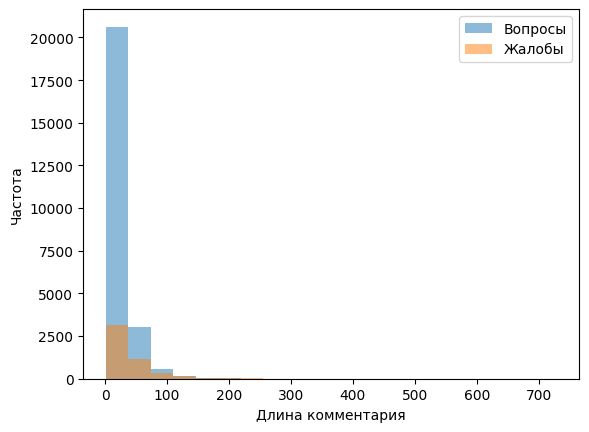

In [5]:
import matplotlib.pyplot as plt

questions_length = [len(comment.split()) for comment in comments[comments['Категория'] == 'Вопрос']['Текст']]
complaints_length = [len(comment.split()) for comment in comments[comments['Категория'] == 'Жалоба']['Текст']]

plt.hist(questions_length, bins=20, alpha=0.5, label='Вопросы')
plt.hist(complaints_length, bins=20, alpha=0.5, label='Жалобы')
plt.legend(loc='upper right')
plt.xlabel('Длина комментария')
plt.ylabel('Частота')

Имеется значительный дисбаланс классов. Текстов с меткой Жалоба - 5000, с меткой Вопрос - 24549. Для оценки качесва нужно использовать более информативную метрику, чем accuracy.
Подавляющее большинство коммментариев имеет длину менее 100.
Для решения задачи классификации можно, после предварительной обработки данных, обучить разные типы моделей и сравнить полученные результаты. 

In [6]:
# Максимальное количество слов 
num_words = 10000
# Максимальная длина комментария
max_comments_len = 120
# Количество классов комментариев
nb_classes = 2

In [7]:

comments['Категория'] = comments['Категория'].map({'Вопрос': 0, 'Жалоба': 1}) #преобразуем классы в числовой вид


In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(comments['Текст'], comments['Категория'], test_size=0.1, random_state=42)
#Делим на тестовую и тренировочную выборку. На тестовой будем оценивать итоговое качество модели, на тренировочной будем обучать и валидировать модель.

In [9]:
tokenizer = Tokenizer(num_words=num_words)

In [10]:
tokenizer.fit_on_texts(X_train)

In [55]:
#tokenizer.word_index 

In [12]:
sequences = tokenizer.texts_to_sequences(X_train)

In [13]:
index = 1
print(X_train[index])
print(sequences[index])

'[id294938415:bp-88767010_4|Αнастасия], Здравствуйте, подскажите как оспорить результаты по отказу пособия с 8 до 17? Насчитали большую сумму, а по факту меньше. Как быть?спасибо
[390, 31, 800, 132, 244, 2058, 7935, 16, 8857, 4, 2753, 2842, 28, 913, 1417, 949, 2, 858, 1910, 862, 3, 183]


In [14]:
x_train = pad_sequences(sequences, maxlen=max_comments_len)

In [15]:
test_sequences = tokenizer.texts_to_sequences(X_test)
x_test = pad_sequences(test_sequences, maxlen=max_comments_len)

Данные преобраованы и готовы для обучения нейросети. Обучим 4 разных классификатора, подходящих для задачи. Сравним метрики качества 

1) Логистическая регрессия

In [16]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(random_state=42, max_iter=1000)

In [17]:
lr.fit(x_train, y_train)

LogisticRegression(max_iter=1000, random_state=42)

In [18]:
lr.score(x_test, y_test) # accuracy

0.8372250423011844

In [21]:
from sklearn.metrics import roc_auc_score
y_pred = lr.predict(x_test)
roc_auc = roc_auc_score(y_test, y_pred)
roc_auc

0.5199222955219159

2) Сверточная нейросеть

In [22]:
model_cnn = Sequential()
model_cnn.add(Embedding(num_words, 32, input_length=max_comments_len))
model_cnn.add(Conv1D(250, 5, padding='valid', activation='relu'))
model_cnn.add(GlobalMaxPooling1D())
model_cnn.add(Dense(128, activation='relu'))
model_cnn.add(Dense(1, activation='sigmoid'))

In [23]:
from tensorflow.keras.metrics import AUC

model_cnn.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['accuracy',AUC(name='roc_auc')])

In [24]:
#model_cnn.summary()

In [25]:
model_cnn_save_path = 'best_model_cnn.h5'
checkpoint_callback_cnn = ModelCheckpoint(model_cnn_save_path, 
                                      monitor='val_loss',
                                      save_best_only=True,
                                      verbose=1)

In [26]:
history_cnn = model_cnn.fit(x_train, 
                            y_train, 
                            epochs=5,
                            batch_size=128,
                            validation_split=0.1,
                            callbacks=[checkpoint_callback_cnn])

Epoch 1/5
187/187 [==============================] - ETA: 0s - loss: 0.3821 - accuracy: 0.8442 - roc_auc: 0.7811
Epoch 1: val_loss improved from inf to 0.28959, saving model to best_model_cnn.h5
187/187 [==============================] - 27s 136ms/step - loss: 0.3821 - accuracy: 0.8442 - roc_auc: 0.7811 - val_loss: 0.2896 - val_accuracy: 0.8850 - val_roc_auc: 0.8853
Epoch 2/5
187/187 [==============================] - ETA: 0s - loss: 0.2548 - accuracy: 0.9019 - roc_auc: 0.9159
Epoch 2: val_loss improved from 0.28959 to 0.28569, saving model to best_model_cnn.h5
187/187 [==============================] - 22s 120ms/step - loss: 0.2548 - accuracy: 0.9019 - roc_auc: 0.9159 - val_loss: 0.2857 - val_accuracy: 0.8827 - val_roc_auc: 0.8905
Epoch 3/5
187/187 [==============================] - ETA: 0s - loss: 0.1851 - accuracy: 0.9316 - roc_auc: 0.9550
Epoch 3: val_loss did not improve from 0.28569
187/187 [==============================] - 24s 131ms/step - loss: 0.1851 - accuracy: 0.9316 - roc_

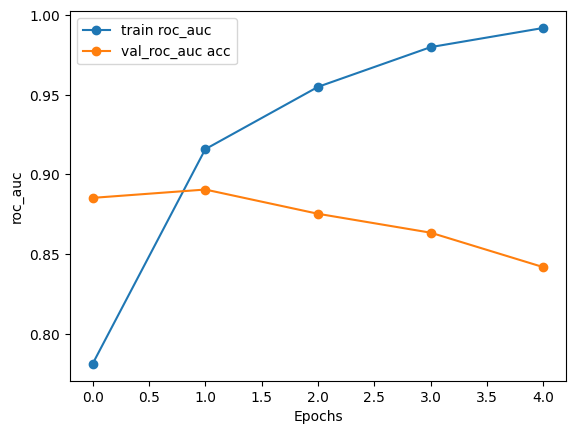

In [27]:
plt.plot(history_cnn.history['roc_auc'], '-o',label='train roc_auc')
plt.plot(history_cnn.history['val_roc_auc'],'-o', label='val_roc_auc acc')
plt.legend()
plt.xlabel('Epochs') 
plt.ylabel('roc_auc') 
plt.show()

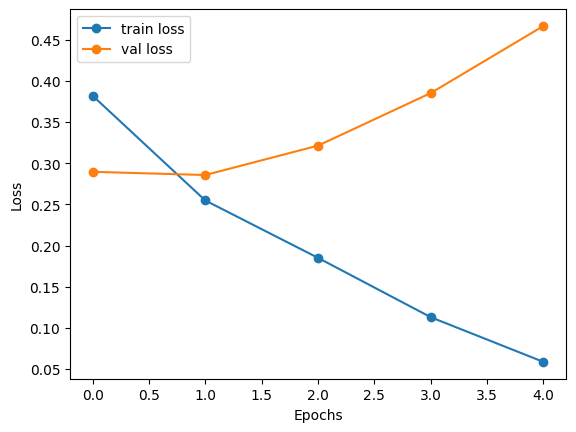

In [28]:
plt.plot(history_cnn.history['loss'], '-o', label='train loss')
plt.plot(history_cnn.history['val_loss'], '-o', label='val loss')
plt.legend()
plt.xlabel('Epochs') 
plt.ylabel('Loss') 
plt.show()

3) LSTM 

In [29]:
model_lstm = Sequential()
model_lstm.add(Embedding(num_words, 32, input_length=max_comments_len))
model_lstm.add(LSTM(16))
model_lstm.add(Dense(1, activation='sigmoid'))

In [30]:
model_lstm.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['accuracy',AUC(name='roc_auc')])

In [31]:
model_lstm.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 120, 32)           320000    
                                                                 
 lstm (LSTM)                 (None, 16)                3136      
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 323,153
Trainable params: 323,153
Non-trainable params: 0
_________________________________________________________________


In [32]:
model_lstm_save_path = 'best_model_lstm.h5'
checkpoint_callback_lstm = ModelCheckpoint(model_lstm_save_path, 
                                      monitor='val_loss',
                                      save_best_only=True,
                                      verbose=1)

In [33]:
history_lstm = model_lstm.fit(x_train, 
                              y_train, 
                              epochs=5,
                              batch_size=128,
                              validation_split=0.1,
                              callbacks=[checkpoint_callback_lstm])

Epoch 1/5
187/187 [==============================] - ETA: 0s - loss: 0.4460 - accuracy: 0.8278 - roc_auc: 0.6844
Epoch 1: val_loss improved from inf to 0.31787, saving model to best_model_lstm.h5
187/187 [==============================] - 18s 80ms/step - loss: 0.4460 - accuracy: 0.8278 - roc_auc: 0.6844 - val_loss: 0.3179 - val_accuracy: 0.8560 - val_roc_auc: 0.8645
Epoch 2/5
187/187 [==============================] - ETA: 0s - loss: 0.2899 - accuracy: 0.8781 - roc_auc: 0.8961
Epoch 2: val_loss improved from 0.31787 to 0.29323, saving model to best_model_lstm.h5
187/187 [==============================] - 14s 77ms/step - loss: 0.2899 - accuracy: 0.8781 - roc_auc: 0.8961 - val_loss: 0.2932 - val_accuracy: 0.8741 - val_roc_auc: 0.8815
Epoch 3/5
187/187 [==============================] - ETA: 0s - loss: 0.2368 - accuracy: 0.9086 - roc_auc: 0.9317
Epoch 3: val_loss did not improve from 0.29323
187/187 [==============================] - 14s 77ms/step - loss: 0.2368 - accuracy: 0.9086 - roc_a

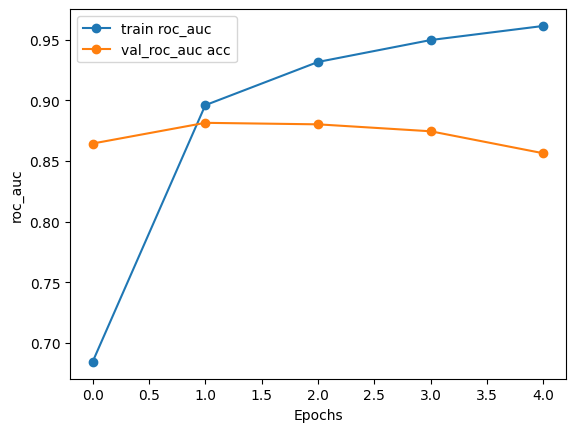

In [34]:
plt.plot(history_lstm.history['roc_auc'], '-o',label='train roc_auc')
plt.plot(history_lstm.history['val_roc_auc'],'-o', label='val_roc_auc acc')
plt.legend()
plt.xlabel('Epochs') 
plt.ylabel('roc_auc') 
plt.show()

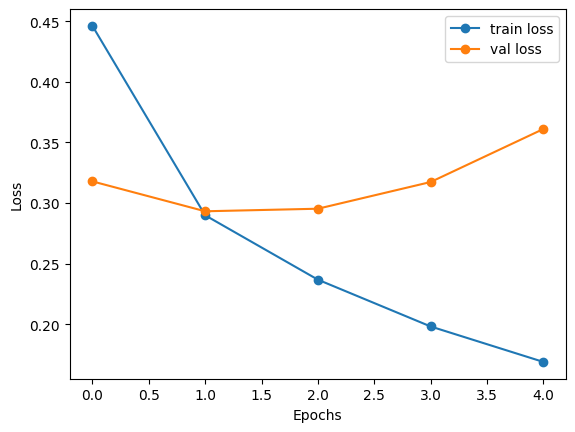

In [35]:
plt.plot(history_lstm.history['loss'], '-o', label='train loss')
plt.plot(history_lstm.history['val_loss'], '-o', label='val loss')
plt.legend()
plt.xlabel('Epochs') 
plt.ylabel('Loss') 
plt.show()

4) GRU


In [36]:
model_gru = Sequential()
model_gru.add(Embedding(num_words, 32, input_length=max_comments_len))
model_gru.add(GRU(16))
model_gru.add(Dense(1, activation='sigmoid'))

In [37]:
model_gru.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['accuracy',AUC(name='roc_auc')])

In [38]:
model_gru_save_path = 'best_model_gru.h5'
checkpoint_callback_gru = ModelCheckpoint(model_gru_save_path, 
                                      monitor='val_loss',
                                      save_best_only=True,
                                      verbose=1)

In [39]:
history_gru = model_gru.fit(x_train, 
                              y_train, 
                              epochs=5,
                              batch_size=128,
                              validation_split=0.1,
                              callbacks=[checkpoint_callback_gru])

Epoch 1/5
187/187 [==============================] - ETA: 0s - loss: 0.4455 - accuracy: 0.8259 - roc_auc: 0.6754
Epoch 1: val_loss improved from inf to 0.33809, saving model to best_model_gru.h5
187/187 [==============================] - 20s 86ms/step - loss: 0.4455 - accuracy: 0.8259 - roc_auc: 0.6754 - val_loss: 0.3381 - val_accuracy: 0.8477 - val_roc_auc: 0.8433
Epoch 2/5
187/187 [==============================] - ETA: 0s - loss: 0.2887 - accuracy: 0.8773 - roc_auc: 0.8936
Epoch 2: val_loss improved from 0.33809 to 0.30407, saving model to best_model_gru.h5
187/187 [==============================] - 15s 82ms/step - loss: 0.2887 - accuracy: 0.8773 - roc_auc: 0.8936 - val_loss: 0.3041 - val_accuracy: 0.8628 - val_roc_auc: 0.8719
Epoch 3/5
187/187 [==============================] - ETA: 0s - loss: 0.2294 - accuracy: 0.9113 - roc_auc: 0.9333
Epoch 3: val_loss did not improve from 0.30407
187/187 [==============================] - 15s 81ms/step - loss: 0.2294 - accuracy: 0.9113 - roc_auc

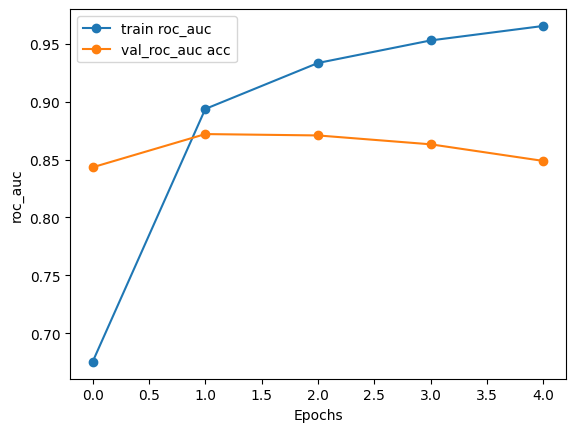

In [40]:
plt.plot(history_gru.history['roc_auc'], '-o',label='train roc_auc')
plt.plot(history_gru.history['val_roc_auc'],'-o', label='val_roc_auc acc')
plt.legend()
plt.xlabel('Epochs') 
plt.ylabel('roc_auc') 
plt.show()

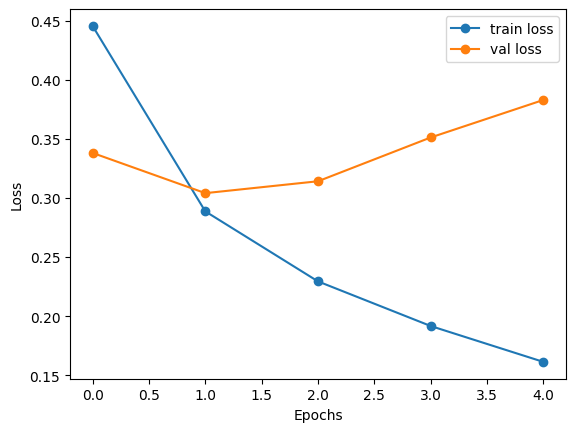

In [41]:
plt.plot(history_gru.history['loss'], '-o', label='train loss')
plt.plot(history_gru.history['val_loss'], '-o', label='val loss')
plt.legend()
plt.xlabel('Epochs') 
plt.ylabel('Loss') 
plt.show()

проверка моделей на тестовом наборе данных, который модель видит впервые.

In [42]:
#model_cnn.load_weights(model_cnn_save_path)
model_cnn.evaluate(x_test, y_test, verbose=1)

93/93 [==============================] - 1s 10ms/step - loss: 0.5111 - accuracy: 0.8575 - roc_auc: 0.8224


[0.5111281275749207, 0.8575296401977539, 0.8223845958709717]

In [43]:
#model_lstm.load_weights(model_lstm_save_path)
model_lstm.evaluate(x_test, y_test, verbose=1)

93/93 [==============================] - 1s 13ms/step - loss: 0.3762 - accuracy: 0.8687 - roc_auc: 0.8357


[0.3762289583683014, 0.8686971068382263, 0.8357478380203247]

In [44]:
#model_gru.load_weights(model_gru_save_path)
model_gru.evaluate(x_test, y_test, verbose=1)

93/93 [==============================] - 1s 12ms/step - loss: 0.3960 - accuracy: 0.8545 - roc_auc: 0.8306


[0.39600837230682373, 0.8544839024543762, 0.8306045532226562]

In [50]:
new_comment = "когда дадут горячую воду?" #проверка предсказания на новом комментарии. предсказание<0.5 - вопрос, иначе - жалоба
new_comment_seq = tokenizer.texts_to_sequences([new_comment])
new_comment_seq_padded = pad_sequences(new_comment_seq, maxlen=max_comments_len)
prediction_gru = model_gru.predict(new_comment_seq_padded)
prediction_cnn = model_cnn.predict(new_comment_seq_padded)
prediction_lstm = model_lstm.predict(new_comment_seq_padded)


1/1 [==============================] - 0s 34ms/step


In [51]:
prediction_lstm

array([[0.01372985]], dtype=float32)

In [52]:
prediction_cnn

array([[0.00028381]], dtype=float32)

In [53]:
prediction_gru

array([[0.01797944]], dtype=float32)

In [49]:
'''if result < 0.5:
    print('Вопрос')
else:
    print('Жалоба')'''


"if result < 0.5:\n    print('Вопрос')\nelse:\n    print('Жалоба')"

93/93 [==============================] - 1s 14ms/step


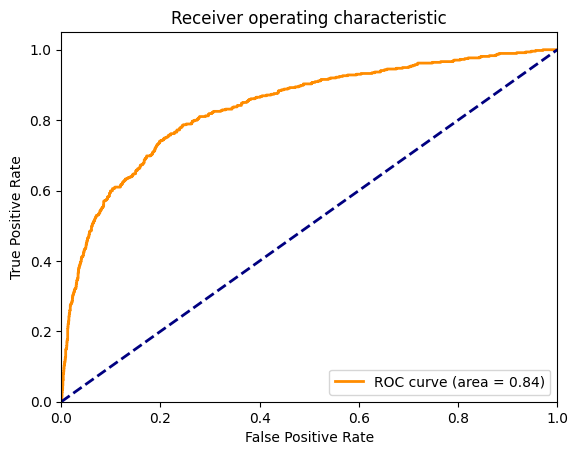

In [54]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
y_pred_lstm = model_lstm.predict(x_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_lstm)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()


Видно, что модели дают примерно одинаковое качество, но все же лучше оказывается lstm. Метрика roc auc, площадь под графиком кривой, оказывается равной 0.84, что является неплохим показателем. Эффективность модели можно улучшить, если добавить в датасет больше комментариев с классом Жалоба, расширить датасет в целом. 